# import

In [ ]:
!lamin init --storage ~/scprint2 --schema bionty

❌ Current instance cannot be reached, close it: `lamin close`
Alternatively, init or load a connectable instance on the command line: `lamin load <instance>` or `lamin init <...>`
Traceback (most recent call last):
  File "/home/ml4ig1/miniconda3/envs/training-gpt/bin/lamin", line 8, in <module>
    sys.exit(main())
  File "/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/lamin_cli/__main__.py", line 162, in main
    return init(
  File "/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/lamindb_setup/_init_instance.py", line 142, in init
    if check_instance_setup() and not _test:
  File "/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/lamindb_setup/_check_instance_setup.py", line 45, in check_instance_setup
    raise e
  File "/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/lamindb_setup/_check_instance_setup.py", line 19, in check_instance_setup
    isettings = load_instance_settings()
  File "/

In [ ]:
import torch
import matplotlib.pyplot as plt

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

from scgpt.trainer import eval_testdata as scgpt_test
from scgpt.preprocess import Preprocessor
from scgpt.model import TransformerModel
from scgpt.utils import load_pretrained
from scgpt.tokenizer.gene_tokenizer import GeneVocab

import sys
sys.path.append("./")
from scgpt_helper import *

import lamindb as ln
import lnschema_bionty as lb
import bionty as bt
lb.settings.organism = "human"

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

  %reload_ext autoreload


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## create experiment

In [ ]:
#experiment = scGExperiment()
batch_keys = [
    "self_reported_ethnicity_ontology_term_id",
    "assay_ontology_term_id",
]
special_tokens = ["<pad>", "<unk>", "<mask>"]
filter_gene_by_counts = 3
data_is_raw = True
save_path = "../save/"


In [ ]:
vocab = "../save/scGPT_human/vocab.json"
model_path = "../save/scGPT_human/best_model.pt"

## prepare dataset

In [ ]:
dataset_name = "retina"

In [ ]:
save_dir = setup(dataset_name, save_path, config)

if type(vocab) is str:
    vocab = GeneVocab.from_file(vocab)
vocab.set_default_index(vocab[config['pad_token']])

scGPT - INFO - save to ../save/_retina-Jan11-10-45


In [ ]:
adata = ln.File.filter(uid=ln.File.search("retina").index[0]).one().load()
# adata = ln.File.filter().first().load()
#ln.Dataset.using("laminlabs/cellxgene-census").one()
dataset = load_dataset(adata, vocab)
dataset.obs["batch_id"] = dataset.obs[batch_keys].apply("_".join, axis=1)
adata

<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


scGPT - INFO - match 25037/37127 genes in vocabulary of size 60697.


/home/ml4ig1/Documents code/scGPT/mytests/scgpt_helper.py:139: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  dataset.var["gene_ids"] = vocab(dataset.var["gene_symbols"].tolist())


AnnData object with n_obs × n_vars = 19694 × 37127
    obs: 'n_genes', 'n_counts', 'percent_mito', 'donor_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'chromosome', 'featureend', 'featurestart', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank', 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'id_in_vocab'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_diffmap', 'X_diffmap_pca', 'X_fitsne', 'X_fle', 'X_pca', 'X_phi', 'X_umap'

## setup

In [ ]:
# experiment.init_datamodule(dataset=, vocab=)

In [ ]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=config['n_hvg'],  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config['n_bins'],  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)

preprocessor(dataset)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.


<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


scGPT - INFO - Binning data ...


In [ ]:
model = TransformerModel(
    len(vocab),  # n_tokens
    # TODO:
    config['embsize'],
    config['nhead'],
    config['d_hid'],
    config['nlayers'],
    vocab=vocab,
    n_cls=9,#len(dataset.obs.cell_type.value_counts()),
    dropout=config['dropout'],
    pad_token=config['pad_token'],
    pad_value=config['pad_value'],
    do_mvc=config['MVC'],
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=1,#len(set(dataset.obs["batch_id"])),
    #domain_spec_batchnorm=config['dsbn'],
    n_input_bins=config['n_bins'],
    #ecs_threshold=config['ecs_thres'],
    #explicit_zero_prob=config['explicit_zero_prob'],
    use_fast_transformer=config['fast_transformer'],
    #pre_norm=config['pre_norm'],
)

/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
if model_path is not None:
    load_pretrained(model, torch.load(model_path), verbose=False)
    # model_config['file'] = model_dir / "args.json"
    # model_file = model_dir / "best_model.pt"
model.to(device)

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(1, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (li

## fine tune and save

In [ ]:
model = fine_tune(
    model, 
    config,
    dataset,
    vocab,
    config['epochs'],
    config['batch_size'],
    save_path,
    device,
)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9b427717e0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f9b43649a20, raw_cell="fine_tune(
    model, 
    config,
    dataset,
  .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bperso/home/ml4ig1/Documents%20code/scGPT/mytests/cleanup_run.ipynb#X30sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


scGPT - INFO - train set number of samples: 15755, 
	 feature length: 2001
scGPT - INFO - valid set number of samples: 3939, 
	 feature length: 2001
hey
hey
random masking at epoch   1, ratio of masked values in train:  0.3998
scGPT - INFO - valid/loss: 23.255262877499884epoch 1
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 354.72s | valid loss/mse 23.2553
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 23.2553
scGPT - INFO - train set number of samples: 15755, 
	 feature length: 2001
scGPT - INFO - valid set number of samples: 3939, 
	 feature length: 2001
hey
hey
random masking at epoch   2, ratio of masked values in train:  0.3998
scGPT - INFO - valid/loss: 23.05727909433869epoch 2
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT 

/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


train/cls,▁▃▄▁▄▁█▁▁▅▂▂▂▅▁▄▁▁▁▁▂▁▁▂▅▁▃▁▄▁▂▁▁▁▂▂▁▂▂▃
train/gep,▂▅█▂▄▇▁▂▅▂▆▄▃▂▅▃▂▂▂▁▃▄▃▂▆▄▂▂▆▅▂▁▂▁▂▅▃▂▄▄
train/cls,0.33092
train/gep,28.76307


970



In [ ]:
load_pretrained(model, torch.load(save_path+"/model_e6.pt"), verbose=False)
model.to(device)

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(1, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (li

## look at what we have

In [ ]:
import sys
sys.path.append('../../scPRINT/scprint/explainer/')
from explainer import scGPT_Explainer

/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/bertviz/head_view.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript
/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/bertviz/model_view.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/bertviz/model_view.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript
<frozen

In [ ]:
dataset.obs.cell_type.unique()

['retinal rod cell', 'native cell', 'OFF-bipolar cell', 'ON-bipolar cell', 'Mueller cell', 'retinal cone cell', 'amacrine cell', 'retinal ganglion cell', 'microglial cell']
Categories (9, object): ['native cell', 'microglial cell', 'amacrine cell', 'retinal cone cell', ..., 'Mueller cell', 'retinal ganglion cell', 'ON-bipolar cell', 'OFF-bipolar cell']

In [ ]:
subdata = dataset[dataset.obs.cell_type=="microglial cell"] #microglial cell, retinal rod cell
explainer = scGPT_Explainer(model, subdata, vocab=vocab)

In [158]:
attn, var_attn, gene_ids = explainer.get_attention()

  6%|▌         | 1/18 [00:00<00:02,  6.75it/s]

100%|██████████| 18/18 [00:01<00:00, 11.67it/s]


(array([  69754.,  141421.,  121155.,   98177.,   81347.,   69291.,
          68949.,   53892.,   43486.,   37002.,   32503.,   29145.,
          26574.,   23764.,   22013.,   20611.,   18948.,   18113.,
          17045.,   16107.,   15138.,   14722.,   13895.,   13409.,
          12793.,   12447.,   12178.,   11825.,   11184.,   10967.,
          10591.,   10404.,   10246.,    9924.,    9648.,    9416.,
           9273.,    9041.,    8962.,    8804.,    8753.,    8519.,
           8593.,    8480.,    8438.,    8254.,    7828.,    7966.,
           7909.,    7880.,    7736.,    7692.,    7721.,    7582.,
           7457.,    7621.,    7525.,    7363.,    7377.,    7466.,
           7658.,    7383.,    7583.,    7486.,    7596.,    7490.,
           7669.,    7747.,    7928.,    7715.,    7895.,    7899.,
           8113.,    8189.,    8299.,    8569.,    8694.,    8789.,
           9078.,    9215.,    9576.,    9924.,   10103.,   10627.,
          10951.,   11302.,   12050.,   12679., 

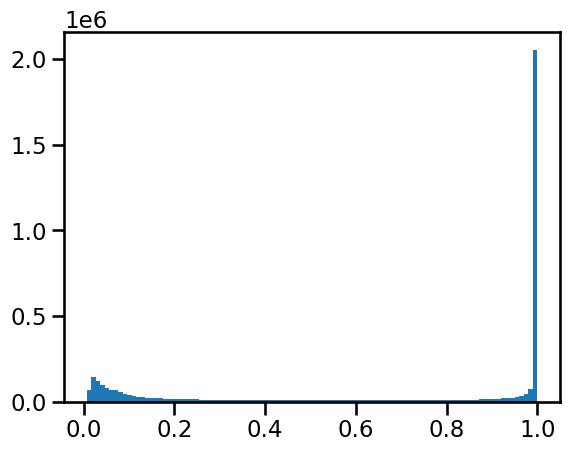

In [ ]:
plt.hist(((var_attn[0]+0.00001)/(0.00001+attn[0])).flatten(), bins=100)

In [193]:
for i in range(0, attn.shape[0]):
    attn[i][(var_attn[i]+0.00001)/(0.00001+attn[i]) > 0.15] = 0
grn = np.sum(attn, axis=0)

In [ ]:
from bertviz import head_view

In [179]:
random_indices = np.random.randint(low=0, high=attn.shape[1], size=80)
todisp = torch.FloatTensor(np.expand_dims(attn[:, random_indices, :][:, :, random_indices],axis=0))
names = subdata.var['feature_name'].values[random_indices]

In [185]:
head_view([todisp], names)

<IPython.core.display.Javascript object>

In [186]:
(grn>0).sum() / (grn.shape[0]*grn.shape[1])

0.5392091560416693

In [ ]:
from grnndata import GRNAnnData
from grnndata import utils 

In [196]:
# if create a view of an AnnData, need to call copy()
# the first value in this array is the cell embedding, not a gene.
grn = GRNAnnData(subdata.copy(), grn=grn[1:,1:])

## ask basic questions to the GRN

In [188]:
# microglia
top_central_genes = utils.get_centrality(grn)
grn.var.loc[[i[0] for i in top_central_genes],'feature_name']

Top central genes: [('ENSG00000002933', 0.02610535850416804), ('ENSG00000007168', 0.02610535850416804), ('ENSG00000010278', 0.02610535850416804), ('ENSG00000014641', 0.02610535850416804), ('ENSG00000018280', 0.02610535850416804), ('ENSG00000026025', 0.02610535850416804), ('ENSG00000026297', 0.02610535850416804), ('ENSG00000046653', 0.02610535850416804), ('ENSG00000051523', 0.02610535850416804), ('ENSG00000059804', 0.02610535850416804), ('ENSG00000065135', 0.02610535850416804), ('ENSG00000067064', 0.02610535850416804), ('ENSG00000067225', 0.02610535850416804), ('ENSG00000067560', 0.02610535850416804), ('ENSG00000068697', 0.02610535850416804), ('ENSG00000074800', 0.02610535850416804), ('ENSG00000075142', 0.02610535850416804), ('ENSG00000075415', 0.02610535850416804), ('ENSG00000075624', 0.02610535850416804), ('ENSG00000078668', 0.02610535850416804), ('ENSG00000081237', 0.02610535850416804), ('ENSG00000082074', 0.02610535850416804), ('ENSG00000085063', 0.02610535850416804), ('ENSG00000086

gene_ids
ENSG00000002933    TMEM176A
ENSG00000007168    PAFAH1B1
ENSG00000010278         CD9
ENSG00000014641        MDH1
ENSG00000018280     SLC11A1
ENSG00000026025         VIM
ENSG00000026297     RNASET2
ENSG00000046653       GPM6B
ENSG00000051523        CYBA
ENSG00000059804      SLC2A3
ENSG00000065135       GNAI3
ENSG00000067064        IDI1
ENSG00000067225         PKM
ENSG00000067560        RHOA
ENSG00000068697     LAPTM4A
ENSG00000074800        ENO1
ENSG00000075142         SRI
ENSG00000075415     SLC25A3
ENSG00000075624        ACTB
ENSG00000078668       VDAC3
ENSG00000081237       PTPRC
ENSG00000082074        FYB1
ENSG00000085063        CD59
ENSG00000086300       SNX10
ENSG00000086730        LAT2
ENSG00000087460        GNAS
ENSG00000089220       PEBP1
ENSG00000089327       FXYD5
ENSG00000090104        RGS1
ENSG00000090238       YPEL3
Name: feature_name, dtype: category
Categories (2000, object): ['A2M', 'AACS', 'AANAT', 'ABCB1', ..., 'ZMAT4', 'ZNF804A', 'ZNF812P', 'ZNRF1']

In [ ]:
#cones
top_central_genes = utils.get_centrality(grn)
grn.var.loc[[i[0] for i in top_central_genes],'feature_name']

Top central genes: [('ENSG00000001461', 0.030758883171933152), ('ENSG00000010404', 0.030758883171933152), ('ENSG00000014641', 0.030758883171933152), ('ENSG00000022267', 0.030758883171933152), ('ENSG00000042753', 0.030758883171933152), ('ENSG00000046653', 0.030758883171933152), ('ENSG00000047849', 0.030758883171933152), ('ENSG00000051620', 0.030758883171933152), ('ENSG00000052802', 0.030758883171933152), ('ENSG00000057757', 0.030758883171933152), ('ENSG00000059804', 0.030758883171933152), ('ENSG00000060138', 0.030758883171933152), ('ENSG00000067064', 0.030758883171933152), ('ENSG00000067225', 0.030758883171933152), ('ENSG00000067560', 0.030758883171933152), ('ENSG00000067606', 0.030758883171933152), ('ENSG00000068697', 0.030758883171933152), ('ENSG00000068971', 0.030758883171933152), ('ENSG00000069849', 0.030758883171933152), ('ENSG00000074317', 0.030758883171933152), ('ENSG00000074800', 0.030758883171933152), ('ENSG00000075142', 0.030758883171933152), ('ENSG00000075415', 0.030758883171

gene_ids
ENSG00000001461     NIPAL3
ENSG00000010404        IDS
ENSG00000014641       MDH1
ENSG00000022267       FHL1
ENSG00000042753      AP2S1
ENSG00000046653      GPM6B
ENSG00000047849       MAP4
ENSG00000051620      HEBP2
ENSG00000052802      MSMO1
ENSG00000057757     PITHD1
ENSG00000059804     SLC2A3
ENSG00000060138       YBX3
ENSG00000067064       IDI1
ENSG00000067225        PKM
ENSG00000067560       RHOA
ENSG00000067606      PRKCZ
ENSG00000068697    LAPTM4A
ENSG00000068971    PPP2R5B
ENSG00000069849     ATP1B3
ENSG00000074317       SNCB
ENSG00000074800       ENO1
ENSG00000075142        SRI
ENSG00000075415    SLC25A3
ENSG00000075624       ACTB
ENSG00000075785      RAB7A
ENSG00000075945     KIFAP3
ENSG00000076043      REXO2
ENSG00000078668      VDAC3
ENSG00000078902     TOLLIP
ENSG00000079459      FDFT1
Name: feature_name, dtype: category
Categories (2000, object): ['A2M', 'AACS', 'AANAT', 'ABCB1', ..., 'ZMAT4', 'ZNF804A', 'ZNF812P', 'ZNRF1']

In [202]:
grn.var_names = grn.var['feature_name']
grn.var['TFs'] = [True if i in utils.TF else False for i in grn.var_names]

/home/ml4ig1/miniconda3/envs/training-gpt/lib/python3.10/site-packages/anndata/_core/anndata.py:949: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['CFH', 'NIPAL3', 'WNT16', 'MAD1L1', 'TMEM176A']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [191]:
#microglia
grn.grn.sum(1).sort_values(ascending=False).head(20)

feature_name
MT-CO1      3.971675
IFI27       3.719180
MT-CO3      3.642034
CYP17A1     3.640886
MT-RNR2     3.578026
SERPING1    3.559206
CD74        3.540354
IFIT2       3.535392
TF          3.524321
NR4A3       3.513894
B2M         3.493739
HLA-DPB1    3.457864
TYROBP      3.434500
TMSB4X      3.430675
HLA-DRA     3.387647
HLA-DRB1    3.360535
CLU         3.353451
S100A9      3.321588
C1QTNF3     3.308875
QPCT        3.290879
dtype: float32

In [ ]:
#cones
grn.grn.sum(1).sort_values(ascending=False).head(20)

feature_name
CHST8       4.046652
RSPO3       3.987358
CA14        3.946459
CCNA1       3.943601
COL21A1     3.925835
LYVE1       3.911230
NOS1        3.910461
SCD         3.900852
QPCT        3.894938
CSRP1       3.882580
OR7E115P    3.877537
KCNK1       3.863492
NGFR        3.852417
NEUROD2     3.843404
ZCCHC12     3.827054
PARM1       3.822857
CDH7        3.822110
SLC15A3     3.821029
ANXA8L1     3.811610
KCNH5       3.808449
dtype: float32

In [197]:
grn.write('grn_micro.h5ad')

... storing 'batch_id' as categorical


In [ ]:
grn.write('grn.h5ad')

... storing 'batch_id' as categorical


In [ ]:
grn

AnnData object with n_obs × n_vars = 12239 × 2000
    obs: 'n_genes', 'n_counts', 'percent_mito', 'donor_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'batch_id'
    var: 'chromosome', 'featureend', 'featurestart', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank', 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'id_in_vocab', 'gene_ids', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'centrality', 'TFs'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 's

In [203]:
grn.grn

feature_name,CFH,NIPAL3,WNT16,MAD1L1,TMEM176A,ICA1,DBNDD1,ARF5,CIAPIN1,TMEM98,...,NEFL,RNVU1-4,PGM5P3-AS1,CCL3,SRD5A2,AC011239.2,LINC01126,ADORA3,FAM237B,MIR5087
feature_name,,,,,,,,,,,,,,,,,,,,,
CFH,0.0,0.001954,0.0,0.002254,0.003288,0.000081,0.0,0.001906,0.000537,0.0,...,0.000916,0.007482,0.000454,0.000288,0.000560,0.000000,0.000062,0.006086,0.000000,0.000548
NIPAL3,0.0,0.004068,0.0,0.000934,0.004307,0.000108,0.0,0.002685,0.003189,0.0,...,0.000098,0.005217,0.000000,0.002102,0.000298,0.000000,0.000000,0.010290,0.000000,0.000445
WNT16,0.0,0.000708,0.0,0.001541,0.001461,0.000061,0.0,0.000908,0.000391,0.0,...,0.000000,0.000827,0.000541,0.002053,0.000000,0.000178,0.000456,0.012430,0.000072,0.000865
MAD1L1,0.0,0.001695,0.0,0.000687,0.005013,0.000079,0.0,0.008322,0.000593,0.0,...,0.000094,0.003764,0.000000,0.002155,0.000106,0.000000,0.000000,0.027640,0.000000,0.000580
TMEM176A,0.0,0.003674,0.0,0.000254,0.008296,0.000498,0.0,0.002132,0.000298,0.0,...,0.000755,0.011331,0.000000,0.000000,0.000000,0.000000,0.000000,0.002315,0.000000,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011239.2,0.0,0.000351,0.0,0.000192,0.005156,0.000000,0.0,0.015850,0.000238,0.0,...,0.000102,0.002080,0.000112,0.000217,0.000686,0.000459,0.000000,0.008321,0.000098,0.000332
LINC01126,0.0,0.001576,0.0,0.000130,0.002164,0.000000,0.0,0.005997,0.000851,0.0,...,0.000212,0.009614,0.000000,0.002001,0.001184,0.000000,0.000000,0.012949,0.000000,0.000235
ADORA3,0.0,0.002346,0.0,0.000186,0.013279,0.000279,0.0,0.001274,0.001266,0.0,...,0.000320,0.019091,0.000069,0.000066,0.000000,0.000000,0.000000,0.000538,0.000000,0.000000


In [205]:
#micro
utils.enrichment(grn, of='Regulators')

2024-01-11 16:34:17,804 [WARNING] Duplicated values found in preranked stats: 0.85% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-01-11 16:34:17,807 [INFO] Parsing data files for GSEA.............................
2024-01-11 16:34:17,808 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:34:17,818 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:34:18,273 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:34:18,308 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:34:18,311 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:34:18,319 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file

[]


ValueError: Warning: No enrich terms when cutoff = 0.25

In [ ]:
#cones
utils.enrichment(grn, of='Regulators')

2024-01-11 14:36:36,661 [WARNING] Duplicated values found in preranked stats: 5.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-01-11 14:36:36,663 [INFO] Parsing data files for GSEA.............................
2024-01-11 14:36:36,665 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:36:36,676 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:36:37,185 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:36:37,238 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:36:37,241 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:36:37,251 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file

[]


ValueError: Warning: No enrich terms when cutoff = 0.25

2024-01-11 16:37:17,897 [INFO] Parsing data files for GSEA.............................
2024-01-11 16:37:17,899 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:37:17,909 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:37:18,411 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:37:18,483 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:37:18,487 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:37:18,496 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:37:19,122 [ERROR] No supported gene_sets: GTEx_Tissue_Sample_Gene_Expression_Profiles_up
2024-01-11 16:37:19,125 [INFO] Enrichr library gene sets already downlo

['GO_Cellular_Component_2015__MHC protein complex (GO:0042611)', 'KEGG_2016__Herpes simplex infection Homo sapiens hsa05168', 'KEGG_2016__Asthma Homo sapiens hsa05310', 'KEGG_2016__Graft-versus-host disease Homo sapiens hsa05332', 'GO_Cellular_Component_2015__ER to Golgi transport vesicle membrane (GO:0012507)', 'GO_Cellular_Component_2015__MHC class II protein complex (GO:0042613)', 'WikiPathways_2016__Allograft Rejection Homo sapiens WP2328', 'KEGG_2016__Type I diabetes mellitus Homo sapiens hsa04940', 'KEGG_2016__Antigen processing and presentation Homo sapiens hsa04612', 'KEGG_2016__Allograft rejection Homo sapiens hsa05330', 'KEGG_2016__Intestinal immune network for IgA production Homo sapiens hsa04672', 'KEGG_2016__Autoimmune thyroid disease Homo sapiens hsa05320', 'KEGG_2016__Inflammatory bowel disease (IBD) Homo sapiens hsa05321', 'KEGG_2016__Rheumatoid arthritis Homo sapiens hsa05323', 'GO_Cellular_Component_2015__integral component of lumenal side of endoplasmic reticulum mem

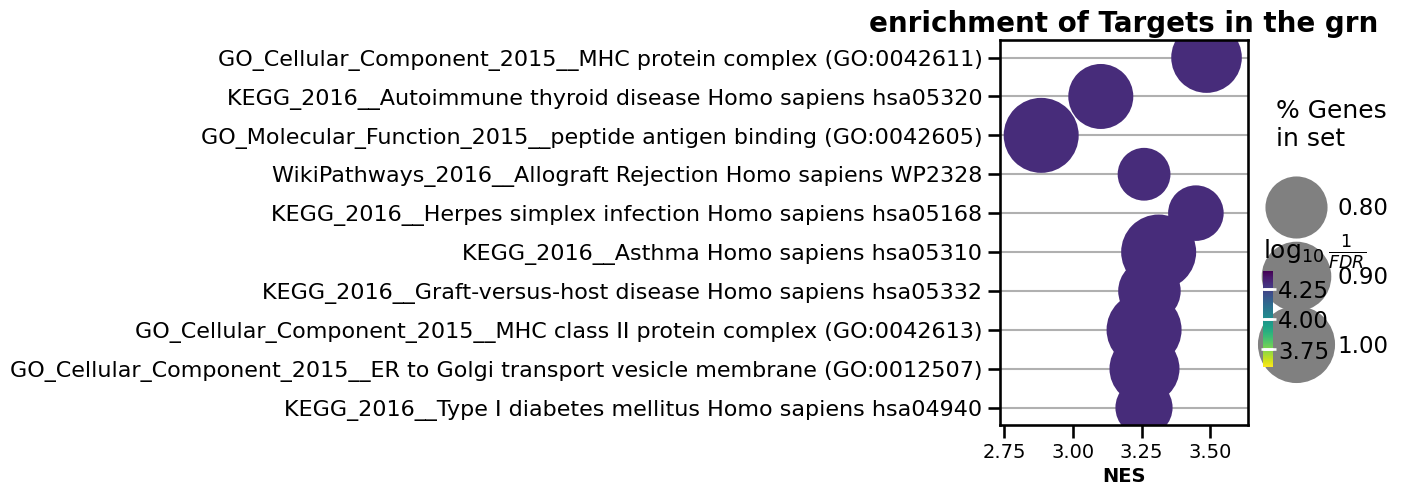

In [209]:
#micro
res = utils.enrichment(grn, of='Targets')

In [214]:
res.iloc[30:60].Term.tolist()

['KEGG_2016__Leishmaniasis Homo sapiens hsa05140',
 'WikiPathways_2016__Apoptosis-related network due to altered Notch3 in ovarian cancer Homo sapiens WP2864',
 'KEGG_2016__Epstein-Barr virus infection Homo sapiens hsa05169',
 'GO_Cellular_Component_2015__trans-Golgi network membrane (GO:0032588)',
 'KEGG_2016__Toxoplasmosis Homo sapiens hsa05145',
 'GO_Cellular_Component_2015__endosome membrane (GO:0010008)',
 'KEGG_2016__Phagosome Homo sapiens hsa04145',
 'GO_Cellular_Component_2015__cytoplasmic vesicle part (GO:0044433)',
 'GO_Cellular_Component_2015__plasma lipoprotein particle (GO:0034358)',
 'GO_Cellular_Component_2015__protein-lipid complex (GO:0032994)',
 'KEGG_2016__HTLV-I infection Homo sapiens hsa05166',
 'celltype.gmt__Langerhans cells',
 'GO_Cellular_Component_2015__clathrin-coated vesicle membrane (GO:0030665)',
 'WikiPathways_2016__Selenium Metabolism and Selenoproteins Homo sapiens WP28',
 'WikiPathways_2016__Selenium metabolism/Selenoproteins Mus musculus WP108',
 'GO_

2024-01-11 14:37:43,492 [INFO] Parsing data files for GSEA.............................
2024-01-11 14:37:43,495 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:37:43,504 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:37:44,017 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:37:44,074 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:37:44,077 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:37:44,086 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:37:44,711 [ERROR] No supported gene_sets: GTEx_Tissue_Sample_Gene_Expression_Profiles_up
2024-01-11 14:37:44,714 [INFO] Enrichr library gene sets already downlo

['KEGG_2016__Neuroactive ligand-receptor interaction Homo sapiens hsa04080', 'KEGG_2016__Staphylococcus aureus infection Homo sapiens hsa05150', 'GO_Cellular_Component_2015__integral component of plasma membrane (GO:0005887)', 'GO_Molecular_Function_2015__extracellular ligand-gated ion channel activity (GO:0005230)', 'Chromosome_Location__chr5p15', 'GO_Molecular_Function_2015__ligand-gated channel activity (GO:0022834)', 'GO_Molecular_Function_2015__ligand-gated ion channel activity (GO:0015276)', 'KEGG_2016__Systemic lupus erythematosus Homo sapiens hsa05322', 'GO_Cellular_Component_2015__chloride channel complex (GO:0034707)', 'GO_Cellular_Component_2015__extracellular region (GO:0005576)']


,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
264,KEGG_2016__Neuroactive ligand-receptor interac...,0.390721,2.965037,0.0,0.000531,0.001,39/57,34.25%,P2RX5;P2RY1;S1PR3;HTR5A;CHRNA2;GRIN2B;OPRK1;CY...
315,KEGG_2016__Staphylococcus aureus infection Hom...,0.487666,2.538607,0.0,0.011416,0.039,19/23,36.40%,FCGR1A;CFI;HLA-DPB1;HLA-DMB;FPR1;C1QC;FCGR2B;C...
341,GO_Cellular_Component_2015__integral component...,0.213427,2.412604,0.0,0.029735,0.137,117/192,45.30%,LYVE1;NGFR;KCNH5;TPBG;P2RX5;P2RY1;GPR37;S1PR3;...
354,GO_Molecular_Function_2015__extracellular liga...,0.441347,2.29744,0.001427,0.069558,0.351,16/23,29.25%,P2RX5;CHRNA2;GRIN2B;GABRG1;GABRR1;GRIA4;GABRA1...
361,Chromosome_Location__chr5p15,0.774824,2.274557,0.0,0.06754,0.41,6/6,22.75%,IRX2;MYO10;IRX4;IRX1;SEMA5A;CTNND2
365,GO_Molecular_Function_2015__ligand-gated chann...,0.356361,2.266412,0.0,0.051884,0.431,23/37,31.20%,KCNK1;P2RX5;KCNJ10;KCNJ6;CHRNA2;GRIN2B;GABRG1;...
366,GO_Molecular_Function_2015__ligand-gated ion c...,0.356361,2.266412,0.0,0.051884,0.431,23/37,31.20%,KCNK1;P2RX5;KCNJ10;KCNJ6;CHRNA2;GRIN2B;GABRG1;...
372,KEGG_2016__Systemic lupus erythematosus Homo s...,0.418975,2.225912,0.001387,0.062125,0.526,18/24,36.40%,FCGR1A;GRIN2B;HLA-DPB1;HLA-DMB;C1QC;HLA-DPA1;H...
376,GO_Cellular_Component_2015__chloride channel c...,0.53178,2.214056,0.001541,0.060709,0.554,10/13,26.90%,GABRG1;GABRR1;GABRA1;GABRA2;GLRA3;GABRG3;FXYD3...
387,GO_Cellular_Component_2015__extracellular regi...,0.183872,2.160125,0.0,0.085328,0.704,130/219,46.95%,RSPO3;COL21A1;NGFR;EFEMP1;TENM1;LY96;LPL;LUZP2...


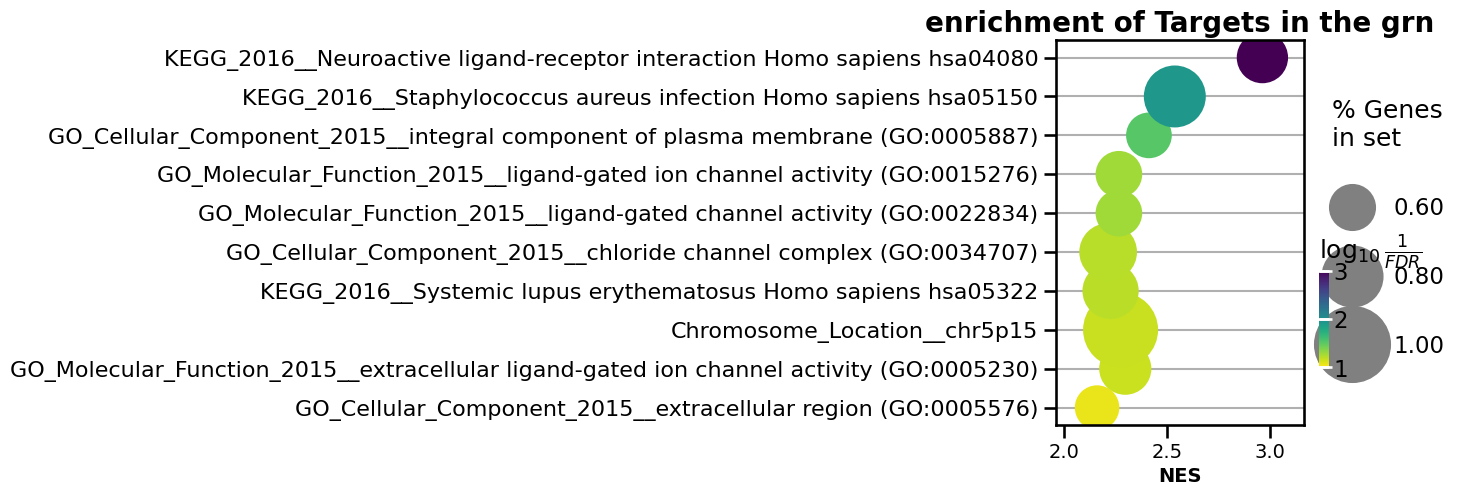

In [ ]:
#cones
utils.enrichment(grn, of='Targets')

Top central genes: []


2024-01-11 16:41:04,861 [WARNING] Duplicated values found in preranked stats: 10.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-01-11 16:41:04,863 [INFO] Parsing data files for GSEA.............................
2024-01-11 16:41:04,865 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:41:04,872 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:41:05,194 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:41:05,211 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:41:05,215 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 16:41:05,221 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local fil

['ENCODE_TF_ChIP-seq_2014__ATF2 GM12878', 'ENCODE_TF_ChIP-seq_2014__NFIC GM12878', 'ENCODE_TF_ChIP-seq_2014__POU2F2 GM12878', 'PPI_Hub_Proteins__SLC2A4', 'ENCODE_TF_ChIP-seq_2014__TBP GM12878', 'ENCODE_TF_ChIP-seq_2014__P300 GM12878', 'ENCODE_TF_ChIP-seq_2014__TEAD4 K562', 'ENCODE_TF_ChIP-seq_2014__SP1 GM12878', 'ENCODE_TF_ChIP-seq_2014__WHIP GM12878', 'PPI_Hub_Proteins__IL7R', 'ENCODE_TF_ChIP-seq_2014__POL2 GM12891', 'ENCODE_TF_ChIP-seq_2014__MTA3 GM12878', 'ENCODE_TF_ChIP-seq_2014__PML GM12878', 'ENCODE_TF_ChIP-seq_2014__EBF1 GM12878', 'ENCODE_TF_ChIP-seq_2014__BRCA1 GM12878', 'GO_Cellular_Component_2015__extracellular vesicular exosome (GO:0070062)', 'ENCODE_TF_ChIP-seq_2014__PML K562', 'ENCODE_TF_ChIP-seq_2014__PAX5 GM12878', 'ENCODE_TF_ChIP-seq_2014__STAT3 GM12878', 'ENCODE_TF_ChIP-seq_2014__MYBL2 HEPG2', 'ENCODE_TF_ChIP-seq_2014__TAF1 GM12878', 'ENCODE_TF_ChIP-seq_2014__JUNB K562', 'ENCODE_TF_ChIP-seq_2014__MEF2A GM12878', 'ENCODE_TF_ChIP-seq_2014__FOXM1 GM12878', 'ENCODE_TF_ChIP

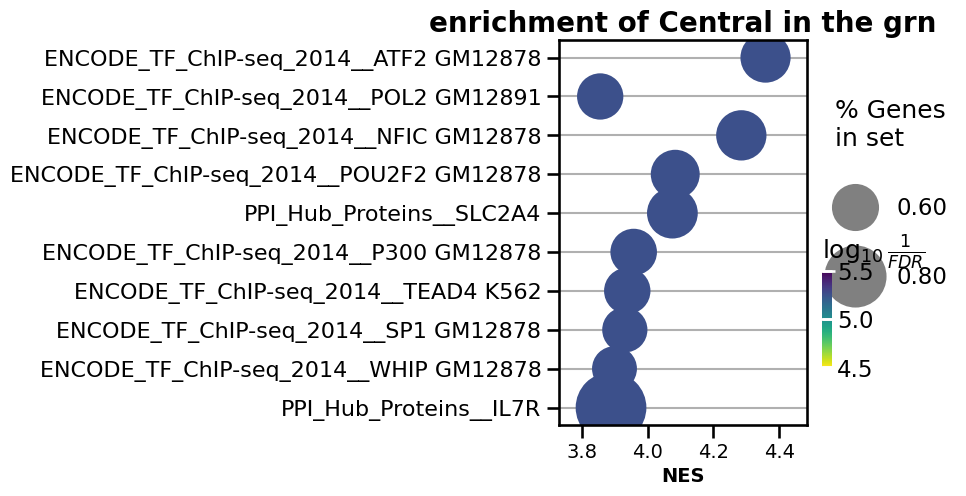

In [215]:
#micro
res = utils.enrichment(grn, of='Central')

In [216]:
res.head(30)

,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,ENCODE_TF_ChIP-seq_2014__ATF2 GM12878,0.418587,4.358279,0.0,0.0,0.0,210/314,35.70%,ALDOA;HSPA8;LAMTOR1;MS4A6A;EIF4A2;RAC1;CACYBP;...
1,ENCODE_TF_ChIP-seq_2014__NFIC GM12878,0.415193,4.284757,0.0,0.0,0.0,210/313,36.10%,ALDOA;CXCR4;HSPA8;LAMTOR1;MZT2B;MS4A6A;EIF4A2;...
2,ENCODE_TF_ChIP-seq_2014__POU2F2 GM12878,0.394864,4.084116,0.0,0.0,0.0,199/305,36.10%,ALDOA;TSC22D3;HSPA8;LAMTOR1;MZT2B;GNAI3;DBI;AL...
3,PPI_Hub_Proteins__SLC2A4,0.503084,4.075489,0.0,0.0,0.0,67/99,24.10%,ALDOA;HSPA8;LAMTOR1;EIF4A2;DYNC1H1;PSMA7;TKT;R...
4,ENCODE_TF_ChIP-seq_2014__TBP GM12878,0.382474,3.994436,0.0,0.0,0.0,206/337,33.45%,ALDOA;CXCR4;TSC22D3;HSPA8;MZT2B;GNAI3;DBI;ALDO...
5,ENCODE_TF_ChIP-seq_2014__P300 GM12878,0.361339,3.957941,0.0,0.0,0.0,311/501,39.25%,ALDOA;CXCR4;HSPA8;LAMTOR1;MZT2B;MS4A6A;EIF4A2;...
6,ENCODE_TF_ChIP-seq_2014__TEAD4 K562,0.37249,3.938465,0.0,0.0,0.0,232/375,36.15%,ALDOA;HSPA8;LAMTOR1;MZT2B;MS4A6A;GNAI3;DBI;ALD...
7,ENCODE_TF_ChIP-seq_2014__SP1 GM12878,0.365218,3.931055,0.0,0.0,0.0,252/418,36.10%,ALDOA;HSPA8;LAMTOR1;MZT2B;MS4A6A;EIF4A2;DBI;AL...
8,ENCODE_TF_ChIP-seq_2014__WHIP GM12878,0.36073,3.899677,0.0,0.0,0.0,264/441,36.05%,ALDOA;CXCR4;TSC22D3;HSPA8;QDPR;GNAI3;ALDOC;DYN...
9,PPI_Hub_Proteins__IL7R,0.663232,3.889157,0.0,0.0,0.0,33/35,30.20%,HSPA8;LDHB;ACTB;CALM1;SRI;ENO1;HSPB1;TUBA1A;CF...


In [218]:
res[~res.Term.str.contains('ENCODE|PPI')].head(30)

,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
15,GO_Cellular_Component_2015__extracellular vesi...,0.352978,3.805262,0.0,0.0,0.0,269/427,39.75%,ALDOA;CXCR4;HSPA8;LAMTOR1;QDPR;GNAI3;DBI;ALDOC...
25,KEGG_2016__Phagosome Homo sapiens hsa04145,0.537112,3.634819,0.0,0.0,0.0,35/51,19.55%,FCGR1A;DYNC1H1;CLEC7A;RAC1;ITGB2;CYBA;FCGR3A;H...
61,GO_Cellular_Component_2015__centrosome (GO:000...,0.609201,3.392762,0.0,0.0,0.0,28/30,35.05%,MZT2B;GNAI3;DYNC1H1;ARL2;CALM1;MDH1;PAFAH1B1;I...
62,WikiPathways_2016__Glycolysis and Gluconeogene...,0.717552,3.389059,0.0,0.0,0.0,16/19,15.55%,ALDOA;ALDOC;GOT1;LDHB;MDH1;SLC2A3;ENO1;PKM;PGK...
63,WikiPathways_2016__Glycolysis and Gluconeogene...,0.717552,3.389059,0.0,0.0,0.0,16/19,15.55%,ALDOA;ALDOC;GOT1;LDHB;MDH1;SLC2A3;ENO1;PKM;PGK...
73,GO_Cellular_Component_2015__microtubule organi...,0.571417,3.308045,0.0,0.0,0.0,30/34,35.05%,MZT2B;GNAI3;DYNC1H1;ARL2;CALM1;MDH1;PAFAH1B1;I...
96,KEGG_2016__Staphylococcus aureus infection Hom...,0.638018,3.203875,0.0,0.0,0.0,20/23,26.65%,FCGR1A;ITGB2;FCGR3A;C3;HLA-DMB;HLA-DMA;HLA-DRB...
111,KEGG_2016__Epstein-Barr virus infection Homo s...,0.5655,3.14177,0.0,0.0,0.0,22/30,19.90%,HSPA8;HLA-A;HLA-E;HLA-C;VIM;YWHAH;HSPA1B;HLA-B...
112,KEGG_2016__Antigen processing and presentation...,0.582964,3.140025,0.0,0.0,0.0,22/27,26.65%,HSPA8;HLA-A;HLA-E;HLA-DMB;HLA-DMA;HLA-C;HSPA1B...
124,GO_Cellular_Component_2015__mitochondrion (GO:...,0.359356,3.076157,0.0,0.0,0.0,63/116,25.60%,QDPR;DBI;ALDOC;FIS1;NOL3;LDHB;CYBA;VDAC1;SLC25...


Top central genes: []


2024-01-11 14:52:38,615 [WARNING] Duplicated values found in preranked stats: 13.55% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-01-11 14:52:38,617 [INFO] Parsing data files for GSEA.............................
2024-01-11 14:52:38,619 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:52:38,626 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:52:38,960 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:52:38,977 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:52:38,979 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-01-11 14:52:38,985 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local fil

['ENCODE_TF_ChIP-seq_2014__NRF1 HELA-S3', 'ENCODE_TF_ChIP-seq_2014__ETS1 A549', 'PPI_Hub_Proteins__SLC2A4', 'ENCODE_TF_ChIP-seq_2014__SIX5 A549', 'ENCODE_TF_ChIP-seq_2014__NRF1 K562', 'ENCODE_TF_ChIP-seq_2014__PML K562', 'ENCODE_TF_ChIP-seq_2014__GABP H3LA3', 'ENCODE_TF_ChIP-seq_2014__ZBTB33 A549', 'ENCODE_TF_ChIP-seq_2014__ELF1 A549', 'ENCODE_TF_ChIP-seq_2014__TRIM28 K562', 'ENCODE_TF_ChIP-seq_2014__GTF2B K562', 'ENCODE_TF_ChIP-seq_2014__MYBL2 HEPG2', 'ENCODE_TF_ChIP-seq_2014__TAF1 GM12892', 'ENCODE_TF_ChIP-seq_2014__GABP HEPG2', 'ENCODE_TF_ChIP-seq_2014__SP2 K562', 'ENCODE_TF_ChIP-seq_2014__NRF1 HEPG2', 'ENCODE_TF_ChIP-seq_2014__POL2 GM12891', 'ENCODE_TF_ChIP-seq_2014__TAF1 PFSK1', 'ENCODE_TF_ChIP-seq_2014__GABP GM12878', 'PPI_Hub_Proteins__IKBKE', 'ENCODE_TF_ChIP-seq_2014__SP1 K562', 'ENCODE_TF_ChIP-seq_2014__CREB1 K562', 'ENCODE_TF_ChIP-seq_2014__GABP HELA-S3', 'ENCODE_TF_ChIP-seq_2014__BCLAF1 K562', 'ENCODE_TF_ChIP-seq_2014__PML GM12878', 'ENCODE_TF_ChIP-seq_2014__SIX5 GM12878', '

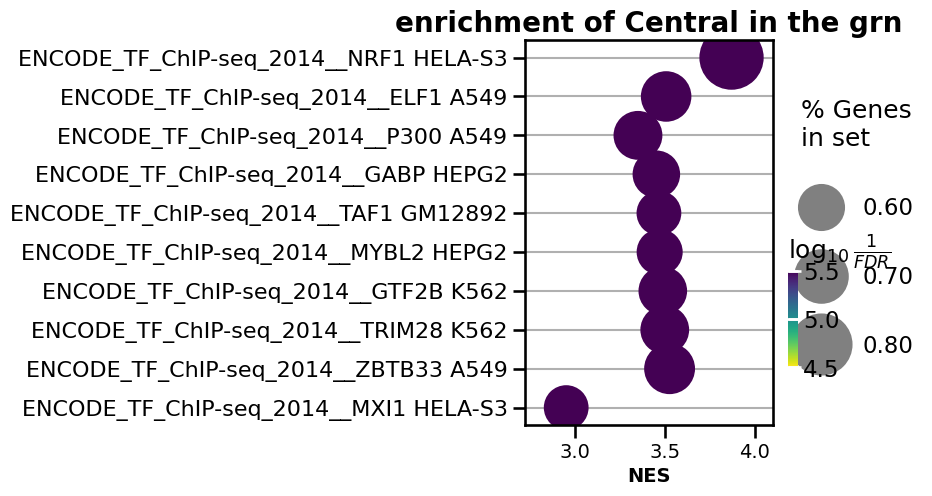

In [ ]:
# cones
res = utils.enrichment(grn, of='Central')

In [ ]:
res[~res.Term.str.contains('ENCODE|PPI')].head(30)

,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
82,GO_Cellular_Component_2015__mitochondrion (GO:...,0.509529,3.152859,0.0,0.0,0.0,67/116,20.25%,COX7A1;PKM;IDI1;DBI;RHOA;FDPS;HEBP2;ECH1;GPX1;...
140,GO_Cellular_Component_2015__microtubule organi...,0.612002,2.948998,0.0,0.0,0.0,27/34,27.05%,DYNLL2;ATP6V0D1;MZT2A;PRKCZ;KIFAP3;MZT2B;TCEA2...
163,GO_Cellular_Component_2015__centrosome (GO:000...,0.617554,2.890645,0.0,0.0,0.0,21/30,16.20%,DYNLL2;ATP6V0D1;MZT2A;KIFAP3;MZT2B;TCEA2;CTNNB...
245,GO_Cellular_Component_2015__peroxisome (GO:000...,0.753874,2.697002,0.0,0.0,0.0,12/13,21.70%,IDI1;ECH1;TKT;PRDX5;SOD1;TRIM37;FIS1;MPV17;VIM...
250,WikiPathways_2016__Glycolysis and Gluconeogene...,0.668618,2.693462,0.0,0.0,0.0,16/19,21.10%,ALDOA;PKM;SLC2A3;PGK1;GPI;GOT1;ENO1;PGAM1;MDH1...
251,WikiPathways_2016__Glycolysis and Gluconeogene...,0.668618,2.693462,0.0,0.0,0.0,16/19,21.10%,ALDOA;PKM;SLC2A3;PGK1;GPI;GOT1;ENO1;PGAM1;MDH1...
257,GO_Cellular_Component_2015__microtubule (GO:00...,0.530901,2.672389,0.0,0.0,0.0,27/41,23.50%,DYNLL2;MAP4;KIF21A;KIFAP3;TUBA1A;DCTN2;DYNLT3;...
261,KEGG_2016__Carbon metabolism Homo sapiens hsa0...,0.647533,2.66218,0.0,0.0,0.0,15/20,17.50%,ALDOA;PKM;PGK1;GPI;GOT1;ENO1;PGP;PGAM1;MDH1;TK...
274,KEGG_2016__Biosynthesis of amino acids Homo sa...,0.699112,2.626319,0.0,0.0,0.0,12/15,17.65%,ALDOA;PKM;PGK1;GOT1;ENO1;PGAM1;TKT;PFKL;ALDOC;...
278,GO_Cellular_Component_2015__microtubule associ...,0.62945,2.612596,0.0,0.000004,0.001,18/21,30.35%,DYNLL2;MAP4;KIF21A;KIFAP3;DCTN2;DYNLT3;KLC1;DY...


In [ ]:
res.head(20)

,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,ENCODE_TF_ChIP-seq_2014__NRF1 HELA-S3,0.680103,3.870927,0.0,0.0,0.0,60/70,24.65%,PITHD1;ATOX1;TRAPPC1;DDX10;CNST;RHOA;ATP6V0D1;...
1,ENCODE_TF_ChIP-seq_2014__ETS1 A549,0.553047,3.677606,0.0,0.0,0.0,138/208,25.10%,ALDOA;LMNA;SNRNP25;JAK1;PITHD1;IDI1;DBI;TRAPPC...
2,PPI_Hub_Proteins__SLC2A4,0.602116,3.658494,0.0,0.0,0.0,70/99,21.05%,ALDOA;LMNA;EEF1A1;EIF4A2;RHOA;GPI;RAB2A;YWHAG;...
3,ENCODE_TF_ChIP-seq_2014__SIX5 A549,0.566626,3.650185,0.0,0.0,0.0,117/165,27.05%,ALDOA;LMNA;SNRNP25;IDI1;TRAPPC1;EEF1A1;EIF4A2;...
4,ENCODE_TF_ChIP-seq_2014__NRF1 K562,0.566527,3.645628,0.0,0.0,0.0,114/167,24.65%,SNRNP25;PITHD1;DBI;TRAPPC1;TSPAN7;EEF1A1;DDX10...
5,ENCODE_TF_ChIP-seq_2014__PML K562,0.528742,3.593804,0.0,0.0,0.0,172/274,25.80%,ALDOA;DYNLL2;SNRNP25;PITHD1;CXXC5;IDI1;DBI;ATO...
6,ENCODE_TF_ChIP-seq_2014__GABP H3LA3,0.604979,3.538342,0.0,0.0,0.0,56/81,19.85%,IDI1;DBI;EIF4A2;FDPS;PGK1;ITGB1BP1;PCMT1;ECH1;...
7,ENCODE_TF_ChIP-seq_2014__ZBTB33 A549,0.572698,3.527345,0.0,0.0,0.0,78/115,21.60%,ALDOA;LMNA;IDI1;DBI;TRAPPC1;EEF1A1;EIF4A2;CNST...
8,ENCODE_TF_ChIP-seq_2014__ELF1 A549,0.523252,3.50817,0.0,0.0,0.0,159/236,30.40%,ALDOA;LMNA;SNRNP25;MAP4;PITHD1;IDI1;DBI;TRAPPC...
9,ENCODE_TF_ChIP-seq_2014__TRIM28 K562,0.555815,3.500552,0.0,0.0,0.0,91/140,21.70%,ALDOA;PITHD1;AP2S1;DBI;EIF4A2;CNST;HEBP2;PGK1;...


## Get embeddings

In [ ]:
# https://scib-metrics.readthedocs.io/en/stable/notebooks/lung_example.html
# https://openproblems.bio/results/batch_integration_embed/
# add pancreas
# add immune
# compute overall mean

## Get classification accuracy

In [ ]:
# https://openproblems.bio/results/label_projection/

## corelation matrix of reconstruction (select the samples carefully)

In [ ]:
# do scib too for this on reconstructed expression without batch information

# denoising

In [ ]:
https://openproblems.bio/results/denoising/

## predict the effects of a KO ()

In [ ]:
# https://www.kaggle.com/competitions/open-problems-single-cell-perturbations